In [1]:
import json

#### Read Original Google Dataset

In [2]:
factuality_data = json.load(open('../data/xsum_hallucination_annotations/factuality_annotations_xsum_summaries.json'))
hallucination_data = json.load(open('../data/xsum_hallucination_annotations/hallucination_annotations_xsum_summaries.json'))

In [3]:
print(len(factuality_data))
print(len(hallucination_data))

5597
11185


In [4]:
factuality_data[2330]

{'bbcid': 33517280,
 'system': 'TranS2S',
 'summary': 'five men have been charged after a protest at heathrow airport led to the closure of a runway at heathrow airport.',
 'is_factual': 'no',
 'worker_id': 'wid_1'}

In [5]:
hallucination_data[0]

{'bbcid': 34687720,
 'system': 'BERTS2S',
 'summary': 'rory mcilroy will take a one-shot lead into the final round of the wgc-hsbc champions after carding a three-under',
 'hallucination_type': 'extrinsic',
 'hallucinated_span': 'rory mcilroy will take a one-shot lead into the final round of the wgc-hsbc champions after carding a three-under',
 'worker_id': 'wid_0'}

#### Read Calculated Probability

In [6]:
google_data_with_proba = json.load(open('../data/Maynez_entity_data_with_prob.json', 'r'))

In [7]:
print(len(google_data_with_proba))

500


In [8]:
for bbcid in google_data_with_proba:
    for system in google_data_with_proba[bbcid]:
        for e in google_data_with_proba[bbcid][system]['ents']:
            if 'cnndm_cmlm_cedar' in e and 'xsum_cmlm_bos' in e:
                e['prior'] = e['bart.large']
                e['posterior'] = e['xsum_cmlm_bos']
            else:
                e['prior'] = None
                e['posterior'] = None

In [9]:
google_data_with_proba['34687720']['Gold']

{'summary': 'rory mcilroy moved to within a shot of joint leaders victor dubuisson and jaco van zyl after the third round of the turkish airlines open.',
 'summary_upper': 'Rory McIlroy moved to within a shot of joint leaders Victor Dubuisson and Jaco van Zyl after the third round of the Turkish Airlines open .',
 'ents': [{'start': 0,
   'end': 4,
   'label': -1,
   'type': 'PERSON',
   'ent': 'Rory',
   'bart.large': 0.380859375,
   'xsum_cmlm_bos': 0.93017578125,
   'cnndm_cmlm_cedar': 0.180908203125,
   'bart.large.xsum': 0.65087890625,
   'prior': 0.380859375,
   'posterior': 0.93017578125},
  {'start': 5,
   'end': 12,
   'label': -1,
   'type': 'PERSON',
   'ent': 'McIlroy',
   'bart.large': 0.9189453125,
   'xsum_cmlm_bos': 0.78173828125,
   'cnndm_cmlm_cedar': 0.81103515625,
   'bart.large.xsum': 0.806640625,
   'prior': 0.9189453125,
   'posterior': 0.78173828125},
  {'start': 53,
   'end': 59,
   'label': -1,
   'type': 'PERSON',
   'ent': 'Victor',
   'bart.large': 0.002313

#### Claculate Factuality Correlation

In [10]:
factuality_data[1]

{'bbcid': 29911712,
 'system': 'BERTS2S',
 'summary': 'more than 50 pupils at a bristol academy have been sent home from school because of a lack of uniform.',
 'is_factual': 'no',
 'worker_id': 'wid_1'}

In [11]:
factuality = {}
for i, f in enumerate(factuality_data):
    if f['bbcid'] not in factuality:
        factuality[f['bbcid']] = {}
    if f['system'] not in factuality[f['bbcid']]:
        factuality[f['bbcid']][f['system']] = []
        
    if f['is_factual'] == 'yes':
        factuality[f['bbcid']][f['system']].append(True)
    elif f['is_factual'] == 'no':
        factuality[f['bbcid']][f['system']].append(False)
    elif f['is_factual'] is None:
        factuality[f['bbcid']][f['system']].append(False)
    else:
        print(i)
        raise Exception('Unkown Label: {}'.format(f['is_factual']))

In [12]:
hallucination = {}
for h in hallucination_data:
    if h['bbcid'] not in hallucination:
        hallucination[h['bbcid']] = {}
    if h['system'] not in hallucination[h['bbcid']]:
        hallucination[h['bbcid']][h['system']] = []
    
    if h['hallucination_type'] == 'extrinsic' and len(h['hallucinated_span']) < len(h['summary']):
        hallucination[h['bbcid']][h['system']].append(h['hallucinated_span'])

In [13]:
hallucination[34687720]['BERTS2S']

['the final round of the wgc-hsbc champions']

In [14]:
# entity in hallucination span (extrinsic), and summary false: false-hallucination
# entity in hallucination span (extrinsic), and summary true: true-hallucnination
# entity not in hallucination span and summary true: non-hallucination

#### Evaluating

In [15]:
from utils import read_document

In [16]:
def check_factual(scores):
    if None in scores: return False
#     if len(scores) == sum(scores):
#         return True
#     else:
#         return False

    if sum(scores) * 2 >= len(scores):
        return True
    else:
        return False

In [17]:
def check_hallucinated(entity, spans):
    for s in spans:
        if entity in s:
            return True
    return False

In [18]:
factual_label, hallucination_label, posterior_label = [], [], []
prior_probs, posterior_probs = [], []
overlap_preds, threshold_preds = [], []

for bbcid in google_data_with_proba:
    for system in google_data_with_proba[bbcid]:
        if int(bbcid) not in factuality or system not in factuality[int(bbcid)]: continue
        if system not in ['BERTS2S']: continue
    
        for e in google_data_with_proba[bbcid][system]['ents']:
            if 'posterior' not in e or e['posterior'] is None: continue
            
            is_factual = check_factual(factuality[int(bbcid)][system])
            is_hallucinated = check_hallucinated(e['ent'], hallucination[int(bbcid)][system])
            is_entity_in_document = e['ent'].lower() in read_document(int(bbcid), '/home/mcao610/scratch/summarization/XSum/xsum-preprocessed/document/').lower()

            if is_factual and is_hallucinated:
                factual_label.append(1)
                hallucination_label.append(1)
            elif is_factual and not is_hallucinated:
                factual_label.append(1)
                hallucination_label.append(0)
            elif (not is_factual) and is_hallucinated:
                factual_label.append(0)
                hallucination_label.append(1)
            elif (not is_factual) and (not is_hallucinated):
                factual_label.append(1)
                hallucination_label.append(0)
            else:
                continue
            
            prior_probs.append(e['prior'])
            posterior_probs.append(e['posterior'])
            
            if e['posterior'] > e['prior']:
                posterior_label.append(1)
            else:
                posterior_label.append(0)
                
            if is_entity_in_document:
                overlap_preds.append(1)
            else:
                overlap_preds.append(0)
                
            if e['posterior'] > 0.4:
                threshold_preds.append(1)
            else:
                threshold_preds.append(0)

In [19]:
print(len(factual_label))
assert len(factual_label) == len(posterior_label)

1309


#### Draw Diagram

In [20]:
%matplotlib inline

from draw import plot_scatter

In [21]:
prior_posterior = []
for pos, pri, f, h in zip(posterior_probs, prior_probs, factual_label, hallucination_label):
    my_label = -1
    if f == 1 and h == 1:
        my_label = 1
    elif f == 0 and h == 1:
        my_label = 2
    elif f == 1 and h == 0:
        my_label = 0
    assert my_label != -1
    prior_posterior.append({'prior': pri, 'posterior': pos, 'label': my_label})

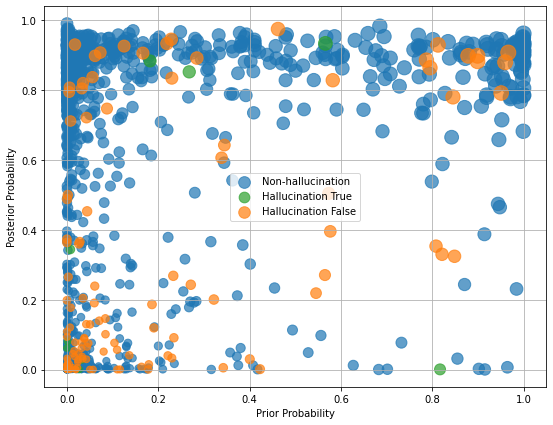

In [22]:
input_data = [
    [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 0],
    [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 1],
    [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 2]
]
labels = ['Non-hallucination', 'Hallucination True', 'Hallucination False']
plot_scatter(input_data, labels)

#### Overlap Baseline

In [23]:
from sklearn.metrics import classification_report

In [24]:
print(classification_report(factual_label, threshold_preds, target_names=['Non-factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-factual     0.1490    0.7200    0.2469       125
     Factual     0.9504    0.5659    0.7094      1184

    accuracy                         0.5806      1309
   macro avg     0.5497    0.6429    0.4781      1309
weighted avg     0.8738    0.5806    0.6652      1309



In [25]:
print(classification_report(factual_label, overlap_preds, target_names=['Non-factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-factual     0.1324    0.5520    0.2136       125
     Factual     0.9289    0.6182    0.7424      1184

    accuracy                         0.6119      1309
   macro avg     0.5307    0.5851    0.4780      1309
weighted avg     0.8529    0.6119    0.6919      1309



In [26]:
print(classification_report([1 if i == 0 else 0 for i in hallucination_label], overlap_preds, target_names=['Non-factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-factual     0.1478    0.5704    0.2348       135
     Factual     0.9264    0.6218    0.7441      1174

    accuracy                         0.6165      1309
   macro avg     0.5371    0.5961    0.4894      1309
weighted avg     0.8461    0.6165    0.6916      1309



#### LM-based Baseline

In [27]:
print(classification_report(factual_label, posterior_label, target_names=['Non-factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-factual     0.1425    0.4240    0.2133       125
     Factual     0.9232    0.7306    0.8157      1184

    accuracy                         0.7013      1309
   macro avg     0.5328    0.5773    0.5145      1309
weighted avg     0.8486    0.7013    0.7581      1309



In [28]:
print(classification_report([1 if i == 0 else 0 for i in hallucination_label], posterior_label, target_names=['Non-factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-factual     0.1505    0.4148    0.2209       135
     Factual     0.9157    0.7308    0.8129      1174

    accuracy                         0.6982      1309
   macro avg     0.5331    0.5728    0.5169      1309
weighted avg     0.8368    0.6982    0.7518      1309



#### Load KNN Model

In [29]:
import numpy as np
import pickle

In [30]:
def predict(knn_model, posteriors, priors):
    posteriors = np.array(posteriors)
    priors = np.array(priors)

    x_mat = np.vstack([posteriors / np.std(posteriors), priors / np.std(priors)]).transpose()
    # x_mat = np.vstack([posteriors, priors]).transpose()

    return knn_model.predict(x_mat)

In [31]:
# load the model from disk
knn_model = pickle.load(open('classifiers/knn_mlm_clm.pkl', 'rb'))

In [32]:
prediction = predict(knn_model, posterior_probs, prior_probs)

In [33]:
print(classification_report([1 if i == 0 else 0 for i in hallucination_label], prediction, target_names=['Non-hallutionated', 'Hallutionated'], digits=4))

                   precision    recall  f1-score   support

Non-hallutionated     0.1520    0.2296    0.1829       135
    Hallutionated     0.9059    0.8526    0.8785      1174

         accuracy                         0.7884      1309
        macro avg     0.5289    0.5411    0.5307      1309
     weighted avg     0.8281    0.7884    0.8067      1309



In [34]:
# LM + KNN:
#                    precision    recall  f1-score   support

# Non-hallutionated     0.1417    0.3926    0.2083       135
#     Hallutionated     0.9123    0.7266    0.8089      1174

#          accuracy                         0.6921      1309
#         macro avg     0.5270    0.5596    0.5086      1309
#      weighted avg     0.8328    0.6921    0.7470      1309

# Main model (n=5):
#                    precision    recall  f1-score   support

# Non-hallutionated     0.1545    0.3778    0.2194       135
#     Hallutionated     0.9142    0.7624    0.8314      1174

#          accuracy                         0.7227      1309
#         macro avg     0.5344    0.5701    0.5254      1309
#      weighted avg     0.8359    0.7227    0.7683      1309


In [35]:
print(classification_report(factual_label, prediction, target_names=['Non-factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-factual     0.1373    0.2240    0.1702       125
     Factual     0.9122    0.8514    0.8807      1184

    accuracy                         0.7914      1309
   macro avg     0.5247    0.5377    0.5255      1309
weighted avg     0.8382    0.7914    0.8129      1309



In [36]:
# LM + KNN (n=4)
#               precision    recall  f1-score   support

#  Non-factual     0.1389    0.3200    0.1937       125
#      Factual     0.9167    0.7905    0.8490      1184

#     accuracy                         0.7456      1309
#    macro avg     0.5278    0.5553    0.5213      1309
# weighted avg     0.8425    0.7456    0.7864      1309

# Main Model (n=4)
#               precision    recall  f1-score   support

#  Non-factual     0.1373    0.2240    0.1702       125
#      Factual     0.9122    0.8514    0.8807      1184

#     accuracy                         0.7914      1309
#    macro avg     0.5247    0.5377    0.5255      1309
# weighted avg     0.8382    0.7914    0.8129      1309